# OpenAI Cookbook - GPT4o-mini with RAG

Instructions before running this notebook:
1. pip install -r requirements.txt to install the required packages
2. Create a .env file with a valid OpenAI API key

In [143]:
import pandas as pd
import numpy as np
import json
import ast
import time
import tiktoken
import concurrent
from openai import OpenAI
from tqdm import tqdm
from tenacity import retry, wait_random_exponential, stop_after_attempt
from IPython.display import Image, display, HTML
from typing import List

# Load OpenAI API Key from .env file
from dotenv import load_dotenv
load_dotenv() # Load environment variables from .env file

client = OpenAI()

GPT_MODEL = "gpt-4o-mini"  # gpt-4.1-nano, gpt-4o-mini
EMBEDDING_MODEL = "text-embedding-3-large"
EMBEDDING_COST_PER_1K_TOKENS = 0.00013

# Helpful Utility Functions 
To create embeddings via batch + parallelized execution

In [144]:
## Helper functions for batching, and parallelizing the embedding process

#  @retry is a decorator from the tenacity library that adds retry logic to make API calls more robust against temporary failures
#  (e.g., failures due to API rate limits or network issues), it will:
#       - Wait for a random exponential time between 1 and 40 seconds before retrying
#       - Stop after 10 failed attempts
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(10))
def get_embeddings(input: List):
    response = client.embeddings.create(
        input=input,
        model=EMBEDDING_MODEL
    ).data
    return [data.embedding for data in response]

# Splits an iterable into batches of size n. 
def batchify(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx : min(ndx + n, l)]
     
# Batching (using batchify function) and parallel processing (using ThreadPoolExecutor)
def embed_corpus( 
    corpus: List[str], 
    batch_size=64, 
    num_workers=8, 
    max_context_len=8191,
    ):
    # Encode the corpus, truncating to max_context_len
    encoding = tiktoken.get_encoding("cl100k_base") #initializes tokenizer using cl100k_base encoding
    encoded_corpus = [
        encoded_article[:max_context_len] for encoded_article in encoding.encode_batch(corpus)
    ]

    # Calculate corpus statistics: the number of inputs, the total number of tokens, and the estimated cost to embed
    num_tokens = sum(len(article) for article in encoded_corpus)
    cost_to_embed_tokens = num_tokens / 1000 * EMBEDDING_COST_PER_1K_TOKENS
    print(
        f"num_articles={len(encoded_corpus)}, num_tokens={num_tokens}, est_embedding_cost={cost_to_embed_tokens:.2f} USD"
    )

    # Embed the corpus
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        
        futures = [
            executor.submit(get_embeddings, text_batch)
            for text_batch in batchify(encoded_corpus, batch_size)
        ]

        # tqdm progress bar
        with tqdm(total=len(encoded_corpus)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(batch_size)

        embeddings = []
        for future in futures:
            data = future.result()
            embeddings.extend(data)

        return embeddings

# Function to generate embeddings for a given column in a DataFrame
def generate_embeddings(df, column_name):
    # Initialize an empty list to store embeddings
    descriptions = df[column_name].astype(str).tolist()
    embeddings = embed_corpus(descriptions)

    # Add the embeddings as a new column to the DataFrame
    df['embeddings'] = embeddings
    print("Embeddings created successfully.")

# Load the unstructured product data (csv) into a Dataframe

In [145]:
styles_filepath = "data/sample_clothes/sample_styles.csv"
styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt  
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts  
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt  
3  2012.0  Ethnic                  Fabindia Men Blue Kurta  
4  2012.0  Ethnic        Shree Women Multi Colored Patiala  
Opened dataset successfully. Dataset has 1000 items of clothing.


# Create Embeddings from Dataframe (containing unstructured text)

In [146]:
# Creates embeddings for each product description (productDisplayName) 
generate_embeddings(styles_df, 'productDisplayName')
print("Writing embeddings to file ...")
styles_df.to_csv('data/sample_clothes/sample_styles_with_embeddings.csv', index=False)
print("Embeddings successfully stored in sample_styles_with_embeddings.csv")

num_articles=1000, num_tokens=8280, est_embedding_cost=0.00 USD


1024it [00:04, 221.73it/s]                         


Embeddings created successfully.
Writing embeddings to file ...
Embeddings successfully stored in sample_styles_with_embeddings.csv


In [147]:
### Uncomment this section and run if csv file already contains latest embeddings, and you want to skip embedding the corpus again from the previous step:
# # Read the embeddings from the CSV file, load into a dataframe
# styles_df = pd.read_csv('data/sample_clothes/sample_styles_with_embeddings.csv', on_bad_lines='skip')

# # Convert the 'embeddings' column from string representations of lists to actual lists of floats
# styles_df['embeddings'] = styles_df['embeddings'].apply(lambda x: ast.literal_eval(x))

# Continue here if embeddings already loaded into dataframe
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing along with their embeddings.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  \
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt   
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts   
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt   
3  2012.0  Ethnic                  Fabindia Men Blue Kurta   
4  2012.0  Ethnic        Shree Women Multi Colored Patiala   

                                          embeddings  
0  [0.006926022004336119, 0.00024994637351483107,...  
1  [-0.04374878853559494, -0.008918779902160168, ...  

# Building the Matching Algorithm

- custom cosine similarity function to calculate semantic similarity between two product descriptions
- `find_matching_items_with_rag` to search product catalogs and retrieve the most relevant items based on the input query

In [148]:
# Custom function for cosine similarity
def cosine_similarity_manual(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    vec1 = np.array(vec1, dtype=float)
    vec2 = np.array(vec2, dtype=float)

    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Custom retrieval function using cosine similarity
def find_similar_items(input_embedding, embeddings, threshold=0.5, top_k=3):
    """
    Find the most similar items based on cosine similarity.

    Args:
    input_embedding (list): The query embedding.
    embeddings (list): The knowledge store embeddings to search through for the best matches.
    threshold (float): 
        Minimum similarity score for a match to be considered valid. 
        A higher threshold results in closer (better) matches, 
        while a lower threshold allows for more items to be returned but less relevant.
    top_k (int): The number of top similar items to return.

    Returns:
    list: A sorted top-k most similar items.
    """
    
    # Calculate cosine similarity between the input embedding and all other embeddings
    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]
    
    # Filter out any similarities below the threshold
    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]
    
    # Sort the filtered similarities by similarity score
    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # Return the top-k most similar items
    return sorted_indices

# Function to find matching items using RAG
def find_matching_items_with_rag(df_items, item_descs):
   """Take the input item descriptions and find the most similar items based on cosine similarity for each description."""
   
   # Select the embeddings from the DataFrame.
   embeddings = df_items['embeddings'].tolist()

   similar_items = []
   for desc in item_descs:
      # Generate the embedding for the input item
      input_embedding = get_embeddings([desc])    
      # Find the most similar items based on cosine similarity
      similar_indices = find_similar_items(input_embedding, embeddings, threshold=0.6)
      similar_items += [df_items.iloc[i] for i in similar_indices]
    
   return similar_items

# Analysis Module
- gpt-4o-mini to analyze images and extract features like gender, category, and generate new recommended product item descriptions
- Provide the URL of the image for analysis and request the model to identify relevant features


In [149]:
# Analyze an Image using 4o-mini, and return a structred JSON output
# with the following fields: "items", "category", and "gender".
def analyze_image(image_base64, subcategories):
    response = client.chat.completions.create(
        model=GPT_MODEL,
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": """Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender". 
                           Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.
                           The category needs to be chosen between the types in this list: {subcategories}. Use "Tshirts" if a Tshirt item is detected in the image taking more than half of the image.
                           The items field should be a list of items that would go well with the item in the picture but must describe items from a different category. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.
                           You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]
                           Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.
                           
                           Example Input: An image representing a black leather jacket.

                           Example Output: {"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}
                           """,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image_base64}",
                },
                }
            ],
            }
        ]
    )
    # Extract relevant features from the response
    features = response.choices[0].message.content
    return features


# Testing the Prompt with Sample Images

In [150]:
# Utility function to encode the .jpg image into base64 string
import base64

def encode_image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

In [151]:
# Set the path to the images and select a test image
image_path = "data/sample_clothes/sample_images/"
# test_images = ["2133.jpg", "7143.jpg", "4226.jpg"]

# Encode the test image to base64
reference_image = "data/test/portrait-1.jpg"# reference_image = image_path + test_images[0]
encoded_image = encode_image_to_base64(reference_image)
# print(encoded_image)

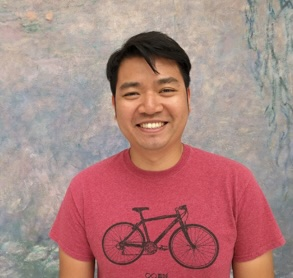

{'items': ['Dark Blue Denim Jeans', 'Classic White Sneakers', 'Black Casual Hoodie'], 'category': 'Tshirts', 'gender': 'Men'}


In [154]:
# Select the unique subcategories from the DataFrame
unique_subcategories = styles_df['articleType'].unique()
# print(f"There are {len(unique_subcategories)} unique subcategories, such as:")
# print(unique_subcategories)

# Analyze the chosen sample image and return the results (calls GPT4o-mini)
analysis = analyze_image(encoded_image, unique_subcategories)
image_analysis = json.loads(analysis)

# Display the image selected and the analysis results (structured JSON output of items, category, and gender)
display(Image(filename=reference_image))
print(image_analysis)
# e.g. {'items': ["Casual Black Men's Jeans", 'White Low-top Sneakers', "Men's Lightweight Hoodie"], 'category': 'T-shirts', 'gender': 'Men'}

# Utilizing RAG to recommend products based on the sampled image analysis

- Output from image analysis includes Gender, Category, and a list of potential product descriptions that matches the analyzed image.
- From the style database, filter for only items of the same gender (or unisex) and different category from the analyzed image.
- We then perform a similarity search using the product descriptions, and return the top 5 most similar items.

In [155]:
# Extract the relevant features from the analysis
item_descs = image_analysis['items']
item_category = image_analysis['category']
item_gender = image_analysis['gender']


# Filter data such that we only look through the items of the same gender (or unisex) and different category
filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]
filtered_items = filtered_items[filtered_items['articleType'] != item_category]
print(str(len(filtered_items)) + " Remaining Items")

# Find the most similar items based on the input item descriptions
matching_items = find_matching_items_with_rag(filtered_items, item_descs)

# Display the matching items (this will display top-k = 3 items for each description in the image analysis)
html = ""
paths = []
for i, item in enumerate(matching_items):
    item_id = item['id']
        
    # Path to the image file
    image_path = f'data/sample_clothes/sample_images/{item_id}.jpg'
    paths.append(image_path)
    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'

# Print the matching item description as a reminder of what we are looking for
print(item_descs)
# Display the image
display(HTML(html))

418 Remaining Items
['Dark Blue Denim Jeans', 'Classic White Sneakers', 'Black Casual Hoodie']


# Guardrails

After obtaining initial suggestions, we can send the original image and the suggested items back to the model. We can then ask GPT-4o mini to evaluate whether each suggested item would indeed be a good fit for the original outfit.

This gives the model the ability to self-correct and adjust its own output based on feedback or additional information. By implementing these guardrails and enabling self-correction, we can enhance the reliability and usefulness of the model's output in the context of fashion analysis and recommendation.



In [156]:
from pydantic import BaseModel

class GuardrailMatchResponse(BaseModel):
    answer: str
    reason: str

def check_match(reference_image_base64, suggested_image_base64):
    response = client.responses.parse(
        model=GPT_MODEL,
        input=[{
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": (
                        """You will be given two images of two different items of clothing. 
                        Your goal is to decide if the items in the images would work in an outfit together. 
                        The first image is the reference item (the item that the user is trying to match with another item). 
                        You need to decide if the second item would work well with the reference item. 
                        The "answer" field must be either "yes" or "no", depending on whether you think the
                        items would work well together. The "reason" field must be a short explanation of your reasoning 
                        for your decision. Do not include the descriptions of the 2 images."""
                    ),
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{reference_image_base64}",
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{suggested_image_base64}",
                },
            ]
        }],
        text_format=GuardrailMatchResponse,
        max_output_tokens=300,
    )

    features = response.output_parsed
    return features

# Validate that recommended products truly complement the outfit

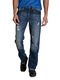

The items match!
The casual nature of the red t-shirt with a bike graphic pairs well with the relaxed feel of the blue jeans, creating a cohesive and comfortable outfit.


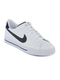

The items match!
The casual style of the t-shirt with a bicycle graphic pairs well with the sporty design of the white Nike shoes, creating a relaxed and coordinated outfit.


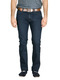

The items match!
The reference item is a casual t-shirt, and the second item is a pair of well-fitting jeans, which typically pairs well with casual tops for a relaxed and stylish look.


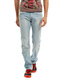

The items match!
The casual t-shirt in the first image would pair well with the light denim jeans in the second image, creating a relaxed and stylish outfit.


In [157]:
# Select the unique paths for the generated images
paths = list(set(paths))

for path in paths:
    # Encode the test image to base64
    suggested_image = encode_image_to_base64(path)
    
    # Check if the items match
    match = check_match(encoded_image, suggested_image)
    match_json = match.model_dump()
    # print(match_json)

    # Parse the JSON response
    # match = json.loads(check_match(encoded_image, suggested_image))
    
    # Display the image and the analysis results
    if match_json["answer"] == 'yes':
        display(Image(filename=path))
        print("The items match!")
        print(match_json["reason"])

## Putting the new look together with Open AI Image Generation
- Combine the original image with the new recommended items
- Use OpenAI image generator to create this new look!

In [ ]:
# Select different styles for generation based on preference
image_styles = [
    "High-Fashion Runway Illustration",
    "Retro 80s/90s anime",
]
image_style = image_styles[0]

# Prompt for Image Generation
prompt = f"""
Keeping the original model outfit, add in new clothing accessories from the other images.\n
The resulting look would be a combined outfit showing off combined items as a new look on one model.\n
The new outfit must be a combination of the original outfit and the new items,\n 
if there are more than one of the same items, just pick one, do not modify the item and keep its original design.\n
Return the image in {image_style} style, with a dark background.\n
Always include the full outfit look including shoes. The shoes must match and be the same as the reference images.
"""

# Image Generation using the Open AI Images API and latest gpt-image-1 model
img = client.images.edit(
  image=[open(reference_image, "rb")] + [open(p, "rb") for p in paths],
  prompt=prompt,
  model="gpt-image-1",
  n=1,
  size="1024x1536",
  quality="medium",
  background="auto",
)

image_base64 = img.data[0].b64_json
image_bytes = base64.b64decode(image_base64)

# Save the image to a file
timestamp = int(time.time()) # make it unique
with open(f"data/test/output_{timestamp}.png", "wb") as f:
    f.write(image_bytes)

# Display the output image in the notebook
from IPython.display import Image, display
cache_buster = int(time.time())
display(HTML(f'<img src="data/test/output_{timestamp}.png?{cache_buster}" width="256" height="384"/>'))